Author: [Yassine Rodani](https://yassine-rodani.info)

# Introduction to Autoencoders

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

In this notebook, I will introduce autoencoders with two examples: image denoising, and anomaly detection.

## Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

## Image denoising

An autoencoder can be trained to remove noise from images. In the following section, I will create a noisy version of the MNIST dataset by applying random noise to each image. I will then train an autoencoder using the noisy image as input, and the original image as the target.

### Useful functions

In [3]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.3
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

In [4]:
def display(array1, array2):
    """
    Displays eight random images from each one of the supplied arrays.
    """

    n = 8

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [5]:
def plot_acc(history):
    """
    Traces accuracy variation on the train and the test set per epoch
    """

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    # Plot: accuracy vs epoch
    plt.figure(figsize=(15,3))
    plt.plot(epochs, acc,label='Training accuracy', linewidth=1.5)
    plt.plot(epochs, val_acc, 'r', label='Test accuracy', linewidth=1.5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.figure()
    plt.show()

In [40]:
def plot_loss(history):
    """
    Traces loss variation on the train and the test set per epoch
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    # Plot: loss values vs epoch
    plt.figure(figsize=(15,3))
    plt.plot(epochs, loss,label='Training loss', linewidth=1.5)
    plt.plot(epochs, val_loss, 'r', label='Test loss', linewidth=1.5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.figure()
    plt.show()

### Load the MNIST dataset

This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reducing the size of the train set to speed up experiences
nnn=1000
x_train = x_train[:nnn]
y_train = y_train[:nnn]

print("x_train",x_train.shape)
print("Number of samples to train:",x_train.shape[0])
print("Number of samples to test:",x_test.shape[0])
print("Classes:",np.unique(y_train))

11501568/11490434 [==============================] - 0s 0us/step
x_train (1000, 28, 28)
Number of samples to train: 1000
Number of samples to test: 10000
Classes: [0 1 2 3 4 5 6 7 8 9]


### Data preprocessing

In [8]:
# Normalizing data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Adding random noise to the images
noisy_x_train = noise(x_train)
noisy_x_test = noise(x_test)

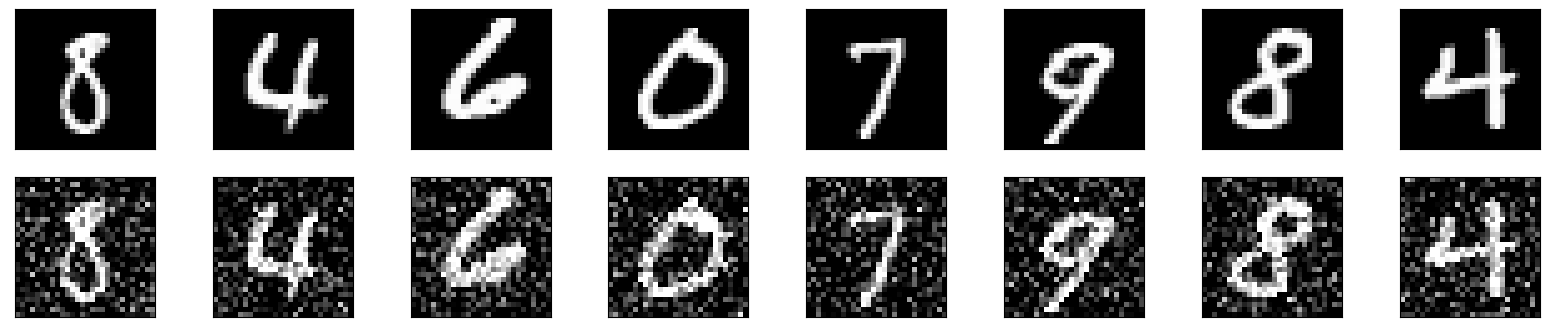

In [19]:
# Plotting some normal images along with a noisy ones
display(x_train, noisy_x_train)

### Build a convolutional autoencoder

In this example, I will train a convolutional autoencoder using [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers in the encoder, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the decoder.

In [10]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

In [11]:
# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

In [12]:
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928 

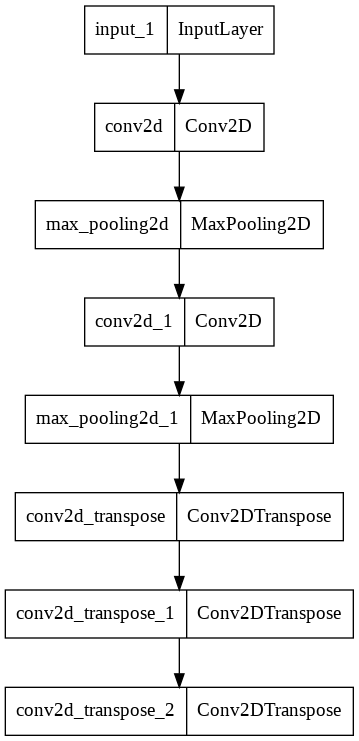

In [20]:
plot_model(autoencoder, to_file='model.png')

Train the model

In [14]:
history = autoencoder.fit(
    noisy_x_train, x_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    verbose=True,
    validation_data=(noisy_x_test, x_test),
)

Epoch 1/100
8/8 [==============================] - 14s 132ms/step - loss: 0.6483 - accuracy: 0.7856 - val_loss: 0.5460 - val_accuracy: 0.8072
Epoch 2/100
8/8 [==============================] - 1s 101ms/step - loss: 0.5166 - accuracy: 0.8107 - val_loss: 0.4833 - val_accuracy: 0.8072
Epoch 3/100
8/8 [==============================] - 1s 101ms/step - loss: 0.4534 - accuracy: 0.8107 - val_loss: 0.4268 - val_accuracy: 0.8072
Epoch 4/100
8/8 [==============================] - 0s 63ms/step - loss: 0.3971 - accuracy: 0.8107 - val_loss: 0.3673 - val_accuracy: 0.8072
Epoch 5/100
8/8 [==============================] - 0s 62ms/step - loss: 0.3349 - accuracy: 0.8107 - val_loss: 0.3043 - val_accuracy: 0.8072
Epoch 6/100
8/8 [==============================] - 1s 101ms/step - loss: 0.2749 - accuracy: 0.8107 - val_loss: 0.2509 - val_accuracy: 0.8072
Epoch 7/100
8/8 [==============================] - 1s 101ms/step - loss: 0.2305 - accuracy: 0.8107 - val_loss: 0.2187 - val_accuracy: 0.8072
Epoch 8/100
8/

Display model's accuracy and losses

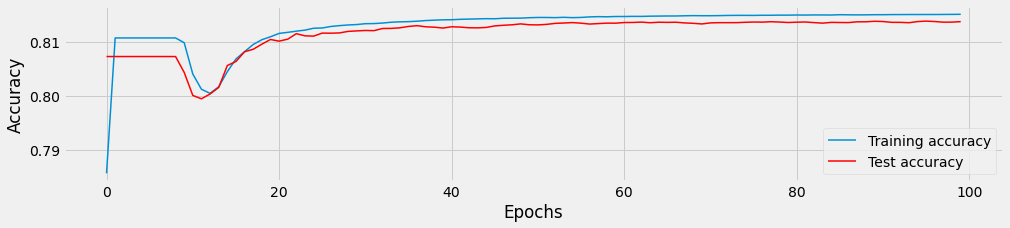

<Figure size 432x288 with 0 Axes>

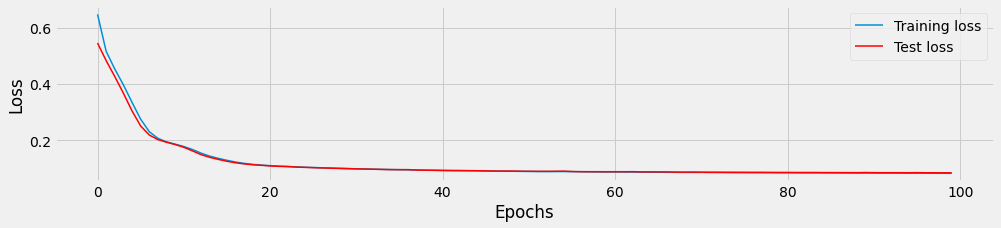

<Figure size 432x288 with 0 Axes>

In [16]:
plt.style.use('fivethirtyeight')
plot_acc(history)
plot_loss(history)
plt.style.use('default')

In [23]:
predictions = autoencoder.predict(noisy_x_test)

Plotting both the noisy images and the denoised images produced by the autoencoder

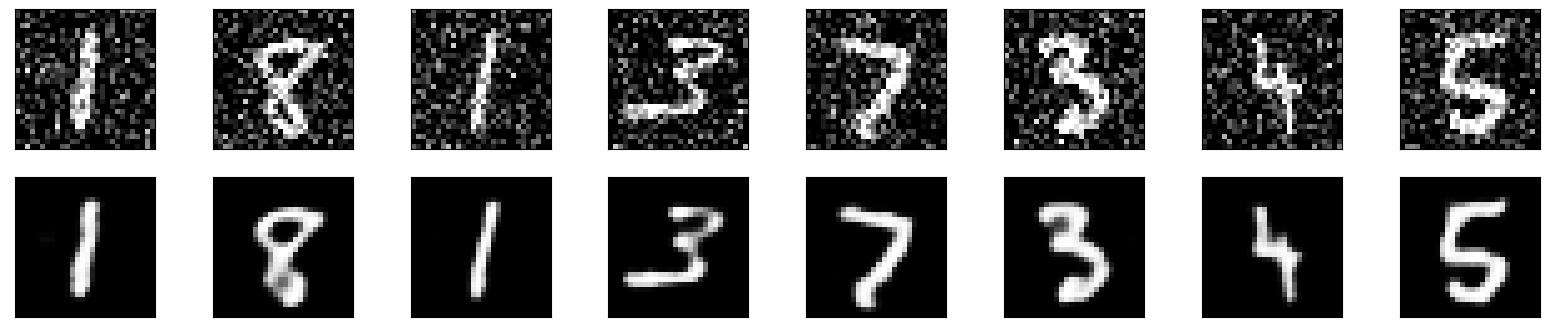

In [25]:
display(noisy_x_test, predictions)

## Anomaly detection

### Overview

In this example, I will train an autoencoder to detect anomalies on the [Numenta Anomaly Benchmark](https://www.kaggle.com/datasets/boltzmannbrain/nab) (NAB) dataset. In particular, I will be using the following data:

- [artificialNoAnomaly](https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv) : Artificially-generated data without any anomalies
- [artificialWithAnomaly](https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv) : Artificially-generated data with varying types of anomalies

### But how will I detect anomalies using an autoencoder?

Recall that an autoencoder is trained to minimize reconstruction error. I will train an autoencoder on the normal sequences only, then use it to reconstruct all the data. Our hypothesis is that the abnormal sequences will have higher reconstruction error. I will then classify a sequence as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load NAB data

In [3]:
nomal_data_path = "https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv"
df_normal = pd.read_csv(nomal_data_path, parse_dates=True, index_col="timestamp")

abnomal_data_path = "https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv"
df_abnormal = pd.read_csv(abnomal_data_path, parse_dates=True, index_col="timestamp")


In [4]:
print(df_normal.head())
print(df_abnormal.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


Visualize some sequences

In [58]:
def plot_sequences():
  """
  Displays a normal and an abnormal sequence
  """
  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(13, 4)
  df_normal.plot(legend=False, ax=ax[0], title='normal')
  df_abnormal.plot(legend=False, ax=ax[1], title='abnormal')
  plt.show()

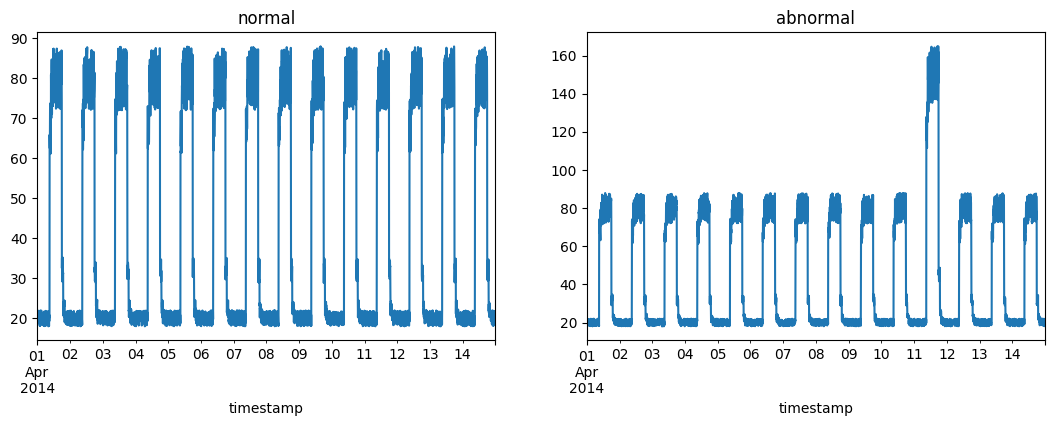

In [59]:
plot_sequences()

### Data preprocessing

In [29]:
# Data normalization
train_mean = df_normal.mean()
train_std = df_normal.std()
train_normalized = (df_normal - train_mean) / train_std
print(f"Number of samples to train: {len(train_normalized)}")

Number of samples to train: 4032


In [30]:
SUBSET_DIM = 300

def create_subsequences(values, dim=SUBSET_DIM):
    """
    Creates a subset with a dimension equals to 300
    """
    output = []
    for i in range(len(values) - dim + 1):
        output.append(values[i : (i + dim)])
    return np.stack(output)

In [31]:
x_train = create_subsequences(train_normalized.values)
print(f"Sample's size: {x_train.shape}")

Sample's size: (3733, 300, 1)


Visualise some sub-sequences

In [73]:
def plot_subsequences(number):
  """
  Displays a number of sub-sequences
  """
  fig, ax = plt.subplots(1,number)
  fig.set_size_inches(number, 6)
  for i in range(0, number * 10, 10):
      ax[int(i/10)].plot(x_train[i])
      ax[int(i/10)].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom = False)
      ax[int(i/10)].tick_params(axis="y", which="both", left=False, right=False, labelleft = False)
  plt.show()

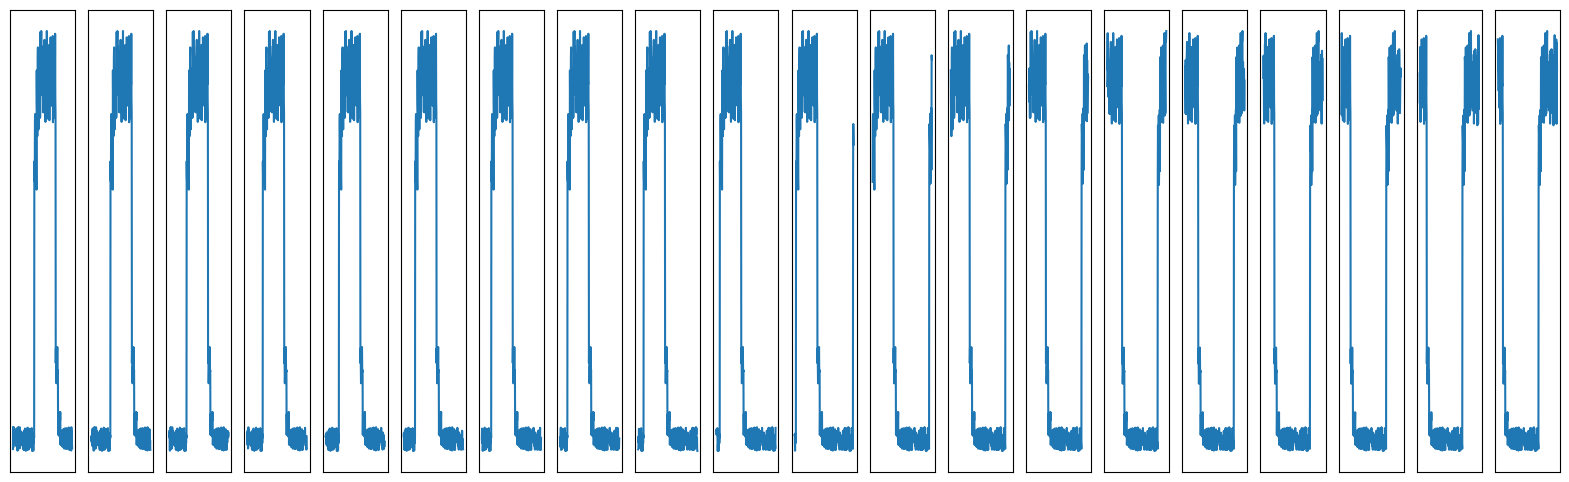

In [75]:
plot_subsequences(20)

### Build a convolutional autoencoder

In this example, I will train a convolutional autoencoder using [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers in the encoder, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the decoder.

In [34]:
input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))

# Encoder
x = layers.Conv1D(32, 7, activation='relu', padding='same')(input)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(16, 7, activation='relu', padding='same')(x)

In [35]:
# Decoder
x = layers.Conv1DTranspose(16, 7, activation='relu', padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(32, 7, activation='relu', padding='same')(x)
x = layers.Conv1DTranspose(1, 7, padding='same')(x)

In [36]:
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 32)           256       
                                                                 
 dropout (Dropout)           (None, 300, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 16)           3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 300, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 300, 16)           0         
                                                             

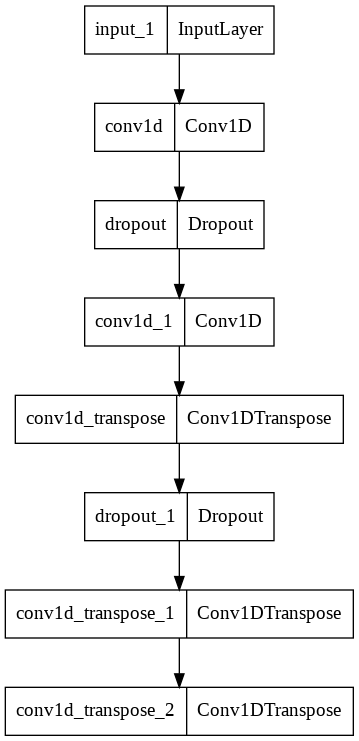

In [37]:
plot_model(autoencoder, to_file='model_2.png')

Train the model

In [38]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    verbose=True,
    validation_split=0.1
)

Epoch 1/50
27/27 [==============================] - 12s 21ms/step - loss: 0.2606 - val_loss: 0.0575
Epoch 2/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0532 - val_loss: 0.0255
Epoch 3/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0352 - val_loss: 0.0230
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0269 - val_loss: 0.0203
Epoch 5/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0225 - val_loss: 0.0226
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0194 - val_loss: 0.0234
Epoch 7/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0221
Epoch 8/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0206
Epoch 9/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0210
Epoch 10/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0169
Epoch 11/50
27/27

Plot model's losses

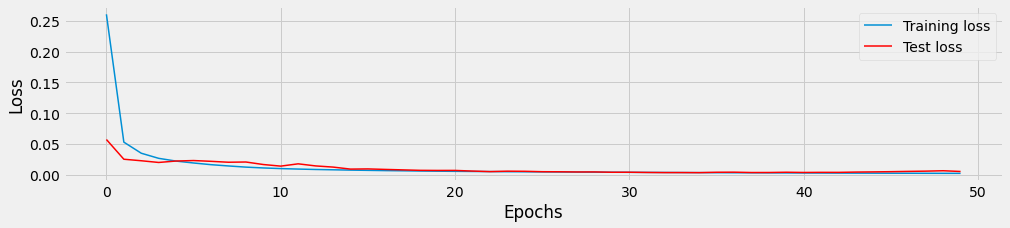

<Figure size 432x288 with 0 Axes>

In [41]:
plt.style.use('fivethirtyeight')
plot_loss(history)
plt.style.use('default')

Display a sequence reconstruction

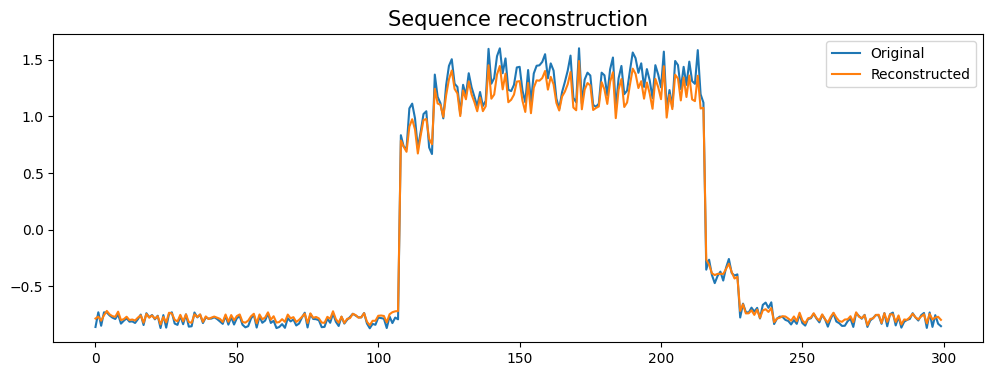

In [42]:
# Predect using the test set
predictions = autoencoder.predict(x_train, verbose=False)

# Sequence reconstruction
plt.figure(figsize=(12,4))
plt.plot(x_train[0], label='Original', linewidth=1.5)
plt.plot(predictions[0], label='Reconstructed', linewidth=1.5)
plt.title("Sequence reconstruction", fontsize=15)
plt.legend(loc='upper right')
plt.show()

### Detecting anomalies

Evaluate reconstruction errors (MAE) for normal subsequences

In [43]:
train_losses = np.mean(np.abs(predictions - x_train), axis=1)

Display reconstruction error distribution for normal subsequences

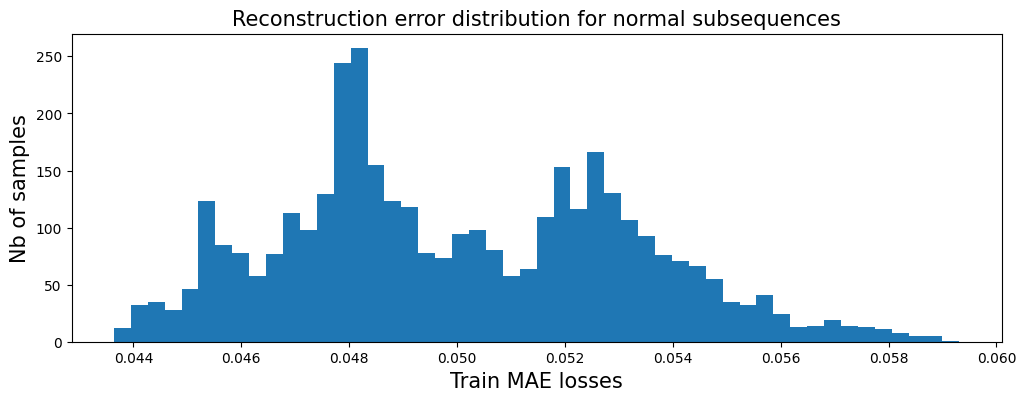

In [50]:
plt.figure(figsize=(12, 4))
plt.hist(train_losses, bins=50)
plt.title('Reconstruction error distribution for normal subsequences', fontsize=15)
plt.xlabel('Train MAE losses', fontsize=15)
plt.ylabel('Nb of samples', fontsize=15)
plt.show()

In [51]:
# Define the maximum value that will constitute the anomaly detection threshold
threshold = np.max(train_losses)
print(f'The maximum value that will constitute the anomaly detection threshold is: {threshold}')

The maximum value that will constitute the anomaly detection threshold is: 0.05931251844406771


Display abnormal subsequences

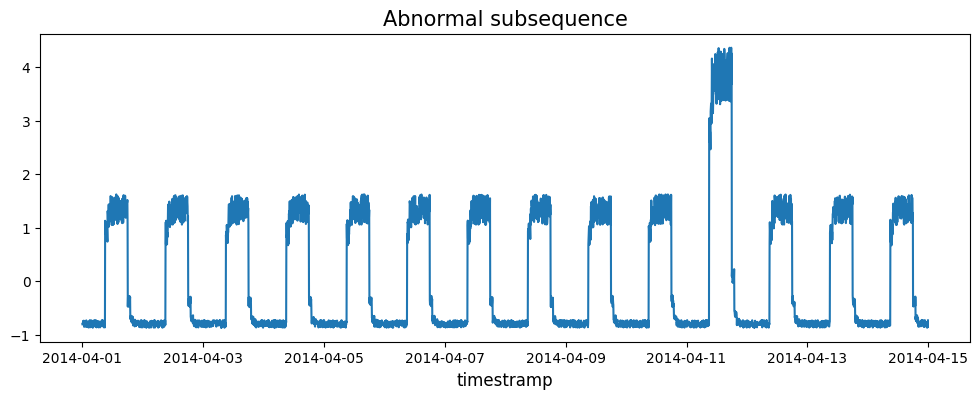

In [72]:
# Data normalization
test_normalized = (df_abnormal - train_mean) / train_std

# Visualisation
plt.figure(figsize=(12,4))
plt.title('Abnormal subsequence', fontsize=15)
plt.plot(test_normalized)
plt.xlabel('timestramp', fontsize=12)
plt.show()

In [62]:
x_test = create_subsequences(test_normalized.values)
print(f"Subsequence's size: {x_test.shape}")

Subsequence's size: (3733, 300, 1)


Predict reconstructions and calculate the abnormal subsequences error

In [63]:
test_predictions = autoencoder.predict(x_test, verbose=False)
test_normalized = np.mean(np.abs(test_predictions - x_test), axis=1)
test_normalized = test_normalized.reshape((-1))

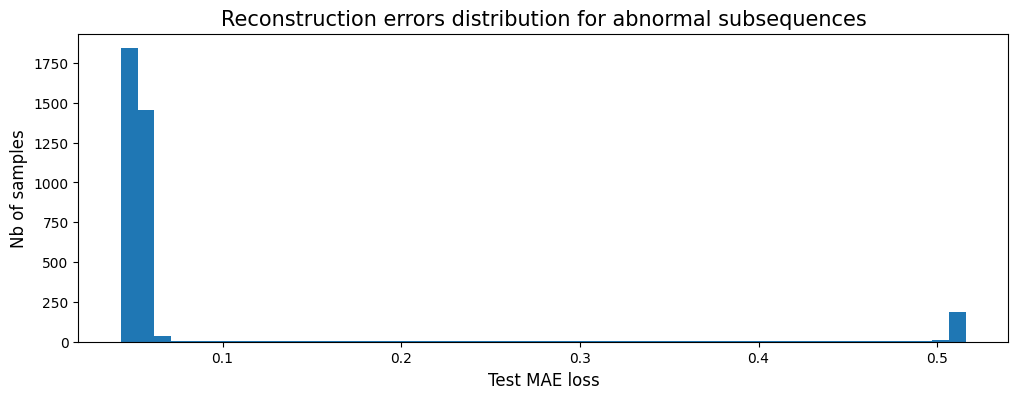

In [65]:
plt.figure(figsize=(12,4))
plt.hist(test_normalized, bins=50)
plt.title('Reconstruction errors distribution for abnormal subsequences', fontsize=15)
plt.xlabel('Test MAE loss', fontsize=12)
plt.ylabel('Nb of samples', fontsize=12)
plt.show()

Get subsequence indexes for whom error is higher than the threshold

In [66]:
anomalies = test_normalized > threshold
print(f'Number of abnormal subsequences: {np.sum(anomalies)}')

Number of abnormal subsequences: 504


In [70]:
anomalies_data_indexes = []

# Iterate through subsequence indexes
for data_idx in range(SUBSET_DIM - 1, len(test_normalized) - SUBSET_DIM + 1):
    # Detect error when (i - SUBSET_DIM + 1) is normal
    if np.all(anomalies[data_idx - SUBSET_DIM + 1 : data_idx]):
        anomalies_data_indexes.append(data_idx)

Display abnormal subsequence with a different color

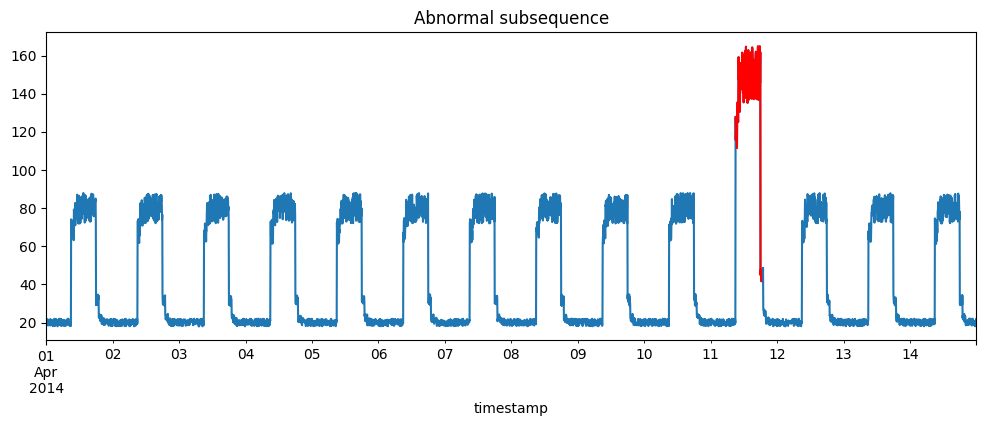

In [71]:
abnormal_subset = df_abnormal.iloc[anomalies_data_indexes]
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
df_abnormal.plot(legend=False, ax=ax)
abnormal_subset.plot(legend=False, ax=ax, color='r')
plt.title('Abnormal subsequence')
plt.show()